In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.sparse import csr_matrix
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from scipy.stats import mannwhitneyu

# 1. CpG clusters connection to RLs (failed)

## Infection
Looks like PCA of distances data doesn't work well and doesn't align with the CpG clusters (i.e., high vs low). This makes sense since we don't need to do a dimensionality reduction as our primary motivation is to cluster and identify if these distance clusters align with the CpG clusters. Hard to visualize k-means since we have 4 features and reducing dimensionality down to 2 using PCA didn't work well. 

### Hierarchical clustering

In [2]:
# Load methylation clusters data as a pandas DataFrame
RL_infection = pd.read_csv('Data/closest_RL_infection_g1.csv', index_col=0)
infection_cpgs_high = pd.read_csv('Data/infection_cpgs_high.csv', index_col=0)
infection_cpgs_low = pd.read_csv('Data/infection_cpgs_low.csv', index_col=0)

# Classifying dataframe with CpG cluster type (i.e., high vs low methylation)
CpG_cluster = []

for cpg in RL_infection.loc[:,'CpG_ID']:
    for high_cluster_id in infection_cpgs_high.loc[:,'CpG_ID']:
        if cpg == high_cluster_id:
            CpG_cluster.append('high')
    for low_cluster_id in infection_cpgs_low.loc[:,'CpG_ID']:
        if cpg == low_cluster_id:
            CpG_cluster.append('low')

RL_infection['CpG_cluster'] = CpG_cluster
closest_RLs = RL_infection.pop('closest_RL')
cpg_ids = RL_infection.pop('CpG_ID')
cpg_cluster = RL_infection.pop('CpG_cluster')

# Standardizing data 
scaler = StandardScaler() # Defining standard scaler to standardize dataframe
RL_infection_standardized = scaler.fit_transform(RL_infection) # Standardizing dataframe
RL_infection_standardized = pd.DataFrame(RL_infection_standardized, columns = ['DHS','enhancer','promoter',
                                                                               'CTCFbs_strong']) 
# Final df with standardized distances of each CpG site to the closest RL type
RL_infection_standardized 

,DHS,enhancer,promoter,CTCFbs_strong
0,-0.394803,0.054447,-0.550050,0.118882
1,-0.941829,-0.096841,-0.549811,0.399142
2,2.402841,-0.173506,-0.540973,0.367781
3,-0.207252,-0.172728,0.014509,0.955448
4,-0.050959,-0.106570,-0.548594,0.353813
...,...,...,...,...
425,1.277532,-0.174771,0.533712,-0.507219
426,0.886799,-0.168155,-0.505700,-0.626555
427,-0.723019,6.577235,5.993006,-0.132541
428,-0.629243,-0.170101,-0.019309,-0.263659


Trying to do cluster/PCA analysis on the entire distances matrix computed for each CpG, but what would that tell us? => If we expect distances of each CpG site to each RL to match a similar pattern, then we should see distinct clusters. 

In [3]:
# Hierarchical cliustering using the distance matrix
distances = np.array(RL_infection_standardized)
linkage_matrix = linkage(distances, method='average') 

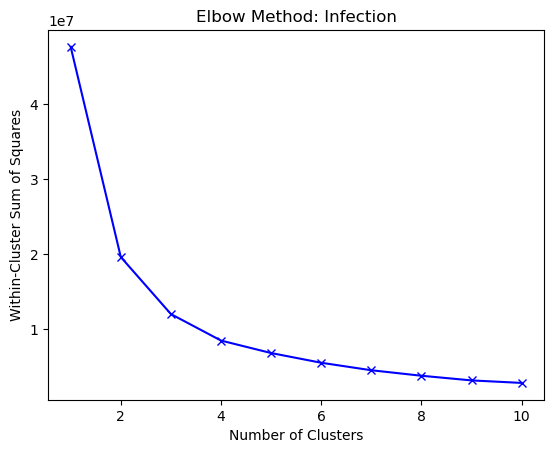

In [4]:
# Choosing the optimal number of clusters using k-means and calculating within-cluster sum of squares for each number 
# of clusters
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(linkage_matrix)
    inertias.append(kmeans.inertia_)

# Plot the number of clusters against the within-cluster sum of squares
plt.plot(range(1, 11), inertias, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method: Infection')
plt.show()

In [5]:
k = 2 # Number of clusters 
labels = fcluster(linkage_matrix, k, criterion='maxclust') 
silhouette_avg = silhouette_score(distances, labels)
print("The average silhouette coefficient is :", silhouette_avg)

The average silhouette coefficient is : 0.8856057399180214


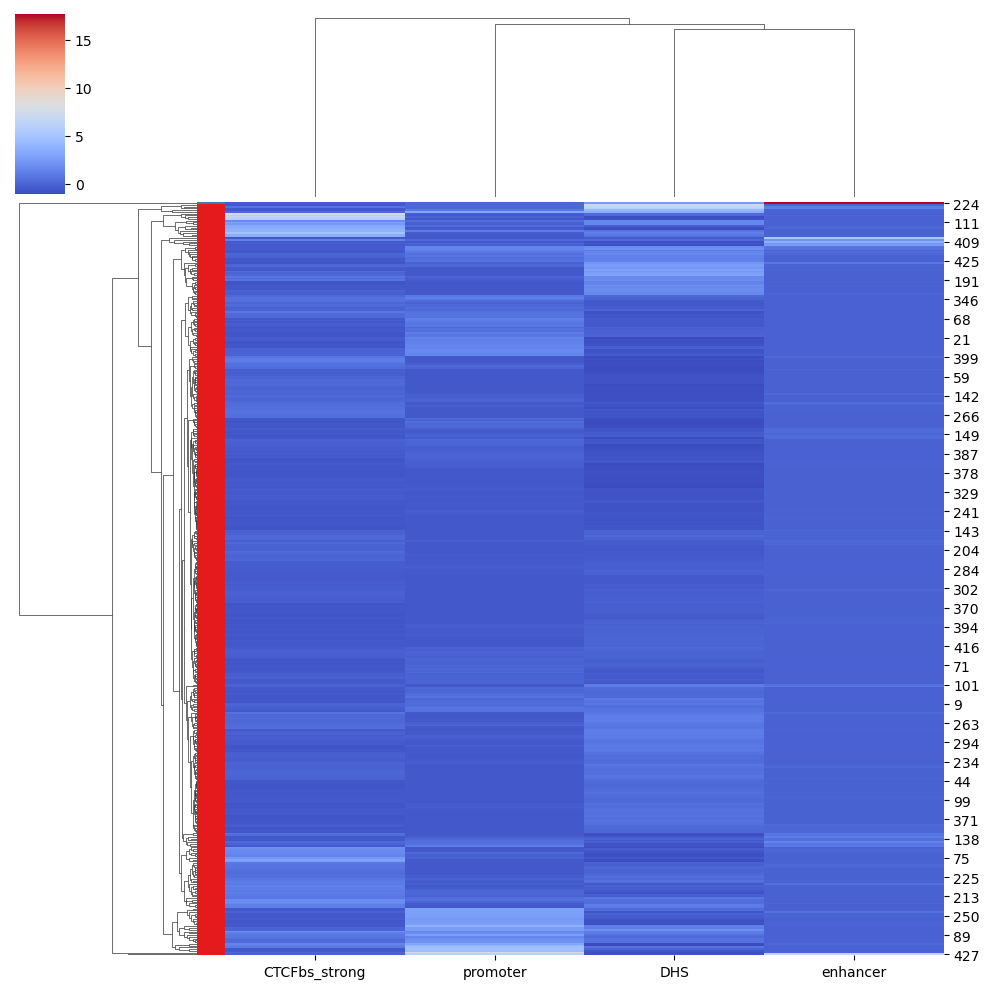

In [6]:
# Generate a clustermap 
# lut = dict(zip(cpg_cluster.unique(), "rbg"))
# row_colors = cpg_cluster.map(lut)
colors = sns.color_palette("Set1", n_colors=k)
row_colors = [colors[label - 1] for label in labels] # Red (cluster 1) is hypo, blue (cluster 2) is hyper
sns.clustermap(RL_infection_standardized, cmap='coolwarm', row_colors=row_colors)

# Display the heatmap
plt.show()

### K-means

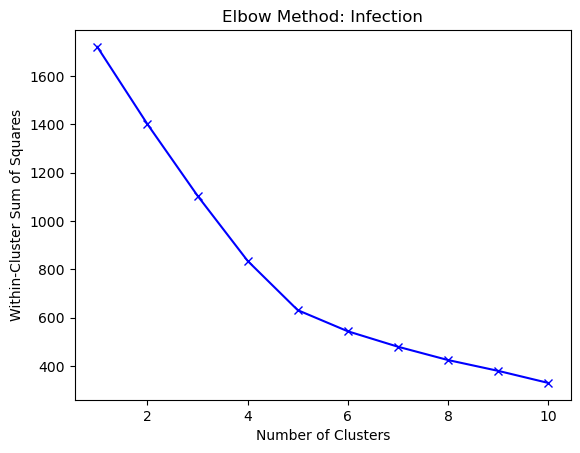

In [7]:
# Choosing the optimal number of clusters using k-means method instead
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(distances)
    inertias.append(kmeans.inertia_)

# Plot the number of clusters against the within-cluster sum of squares
plt.plot(range(1, 11), inertias, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method: Infection')
plt.show()

In [8]:
# K-means clustering using 5 clusters (optimal)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=100)
kmeans.fit(distances)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

silhouette_avg = silhouette_score(distances, labels)
print("The average silhouette coefficient is :", silhouette_avg)
calinski = calinski_harabasz_score(distances, labels)
print("The average Calinski-Harabasz index is :", calinski)
davies = davies_bouldin_score(distances, labels)
print("The average Davies-Bouldin index is :", davies)

The average silhouette coefficient is : 0.42004704959005384
The average Calinski-Harabasz index is : 183.372420726425
The average Davies-Bouldin index is : 0.7372492477714125


In [9]:
# K-means clustering using 2 clsuters
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=100)
kmeans.fit(distances)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

silhouette_avg = silhouette_score(distances, labels)
print("The average silhouette coefficient is :", silhouette_avg)
calinski = calinski_harabasz_score(distances, labels)
print("The average Calinski-Harabasz index is :", calinski)
davies = davies_bouldin_score(distances, labels)
print("The average Davies-Bouldin index is :", davies)

The average silhouette coefficient is : 0.5789056001023761
The average Calinski-Harabasz index is : 93.12769431078421
The average Davies-Bouldin index is : 1.315176863723262


So optimal number of clusters match the best Calinski-Harabasz index.

Text(69.58333333333333, 0.5, 'Data points')

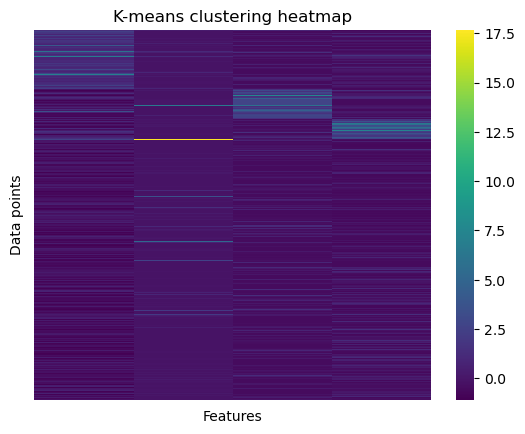

In [82]:
# Visualize k-means clsutering
# Get the sorted index of the clusters
sorted_index = np.argsort(kmeans.labels_)

# Create a heatmap using seaborn
sns.heatmap(distances[sorted_index], cmap='viridis', xticklabels=False, yticklabels=False)

# Add plot title and axis labels
plt.title('K-means clustering heatmap')
plt.xlabel('Features')
plt.ylabel('Data points')

### PCA

In [10]:
k = 2 # Number of clusters 
labels = fcluster(linkage_matrix, k, criterion='maxclust') 
silhouette_avg = silhouette_score(distances, labels)
print("The average silhouette coefficient is :", silhouette_avg)

The average silhouette coefficient is : 0.8856057399180214


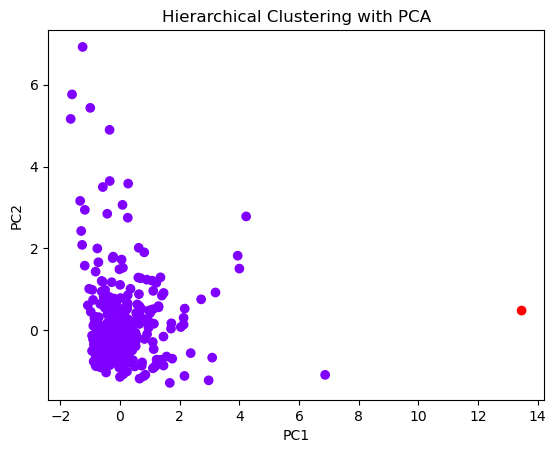

In [11]:
# Perform PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
embedding = pca.fit_transform(distances)

# Plot the data points in a scatterplot based on the clustering labels
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Hierarchical Clustering with PCA')
plt.show()

Variance explained by the first two PCs: 0.5394916699492367


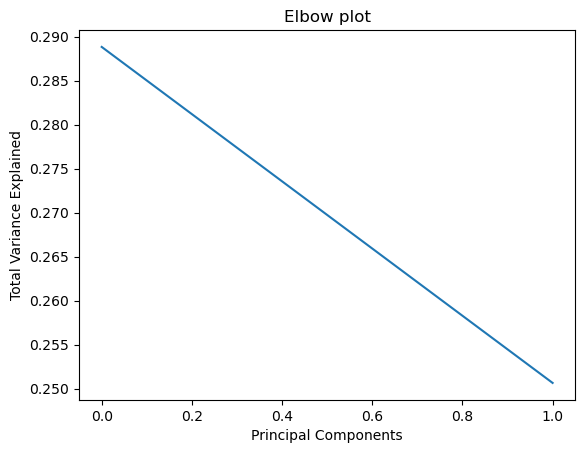

In [12]:
total_variance = pca.explained_variance_ratio_ # Total variance explained against the principal components
print('Variance explained by the first two PCs:', total_variance[0]+total_variance[1])

plt.figure()
plt.plot(total_variance)
plt.xlabel('Principal Components')
plt.ylabel('Total Variance Explained')
plt.title('Elbow plot')
plt.show()

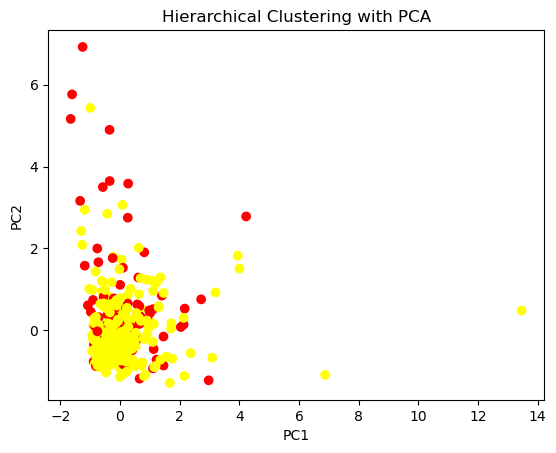

In [13]:
color_dict = {'high': 'red', 'low': 'yellow'} # Creating a dictionary mapping each diagnosis to a color
cpg_cluster_colored = cpg_cluster.map(color_dict)

# Plot the data points in a scatterplot based on the CpG clusters
plt.scatter(embedding[:, 0], embedding[:, 1], c=cpg_cluster_colored, cmap='rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Hierarchical Clustering with PCA')
plt.show()

### Random forest

In [14]:
# Splitting the data into training and testing sets for features (X) and labels (y)
X = RL_infection_standardized
y = cpg_cluster
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, max_depth=5) # Creating a Random Forest classifier with 100 trees 
                                                          # and a maximum depth of 5

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test) # Predicting the target variable for new data

# Evaluating the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6162790697674418


In [22]:
unique_labels = np.unique(y_test)
print(unique_labels)

['high' 'low']


Text(0.5, 1.0, 'Confusion Matrix')

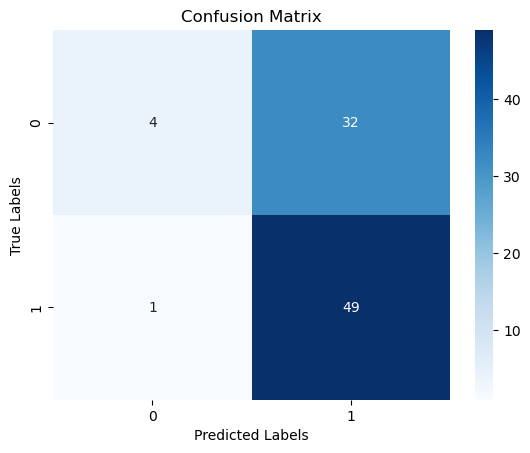

In [20]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels") 
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [137]:
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': RL_infection_standardized.columns.values, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False) # Sorting features by importance
feature_importances

,feature,importance
3,CTCFbs_strong,0.345235
1,enhancer,0.243063
2,promoter,0.229120
0,DHS,0.182582


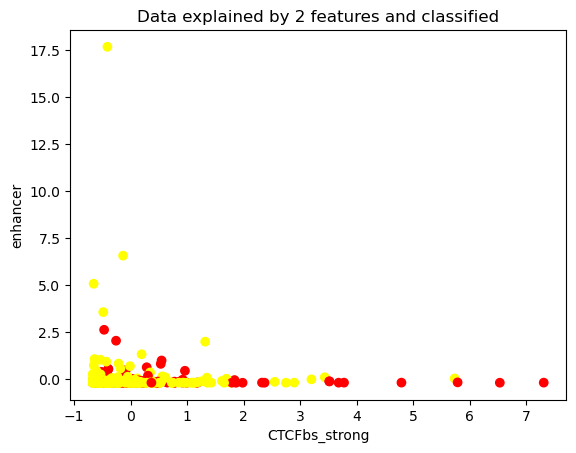

In [142]:
plt.scatter(RL_infection_standardized.iloc[:,3], RL_infection_standardized.iloc[:,1], c=cpg_cluster_colored)
plt.xlabel('CTCFbs_strong')
plt.ylabel('enhancer')
plt.title('Data explained by 2 features and classified')
plt.show()

Makes sense, it's the combo of all RLs that explain the data to classify into hyper vs hypo methylation

## Treatment

### Hierarchical clustering

In [23]:
# Load methylation clusters data as a pandas DataFrame
RL_treatment = pd.read_csv('Data/closest_RL_treatment_g2.csv', index_col=0)
treatment_cpgs_high = pd.read_csv('Data/treatment_cpgs_high.csv', index_col=0)
treatment_cpgs_low = pd.read_csv('Data/treatment_cpgs_low.csv', index_col=0)

# Classifying dataframe with CpG cluster type (i.e., high vs low methylation)
CpG_cluster = []

for cpg in RL_treatment.loc[:,'CpG_ID']:
    for high_cluster_id in treatment_cpgs_high.loc[:,'CpG_ID']:
        if cpg == high_cluster_id:
            CpG_cluster.append('high')
    for low_cluster_id in treatment_cpgs_low.loc[:,'CpG_ID']:
        if cpg == low_cluster_id:
            CpG_cluster.append('low')

RL_treatment['CpG_cluster'] = CpG_cluster
closest_RLs = RL_treatment.pop('closest_RL')
cpg_ids = RL_treatment.pop('CpG_ID')
cpg_cluster = RL_treatment.pop('CpG_cluster')

# Standardizing data 
scaler = StandardScaler() # Defining standard scaler to standardize dataframe
RL_treatment_standardized = scaler.fit_transform(RL_treatment) # Standardizing dataframe
RL_treatment_standardized = pd.DataFrame(RL_treatment_standardized, columns = ['DHS','enhancer','promoter','CTCFbs_strong']) 
RL_treatment_standardized


,DHS,enhancer,promoter,CTCFbs_strong
0,0.279260,-0.165321,-0.492806,-0.584609
1,1.409512,-0.177007,-0.492598,-0.579042
2,6.242684,-0.124362,-0.446784,-0.515207
3,0.354610,-0.168493,-0.492287,0.532445
4,-0.011376,-0.191977,-0.491166,-0.674661
...,...,...,...,...
840,-0.065197,-0.192534,0.357768,-0.527031
841,-0.178222,-0.163373,-0.165694,0.364932
842,0.020917,-0.137829,-0.493304,-0.694358
843,-0.081344,-0.136772,-0.492909,-0.693854


In [24]:
# Hierarchical cliustering using the distance matrix
distances = np.array(RL_treatment_standardized)
linkage_matrix = linkage(distances, method='average') 

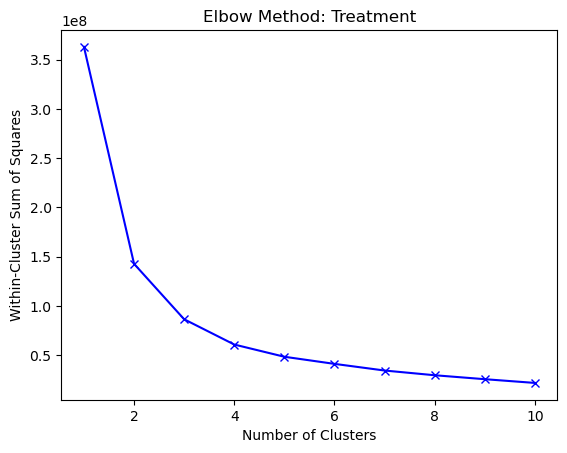

In [25]:
# Choosing the optimal number of clusters using k-means and calculating within-cluster sum of squares for each number 
# of clusters
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(linkage_matrix)
    inertias.append(kmeans.inertia_)

# Plot the number of clusters against the within-cluster sum of squares
plt.plot(range(1, 11), inertias, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method: Treatment')
plt.show()

In [26]:
k = 2 # Number of clusters 
labels = fcluster(linkage_matrix, k, criterion='maxclust') 
silhouette_avg = silhouette_score(distances, labels)
print("The average silhouette coefficient is :", silhouette_avg)

The average silhouette coefficient is : 0.905901430035035


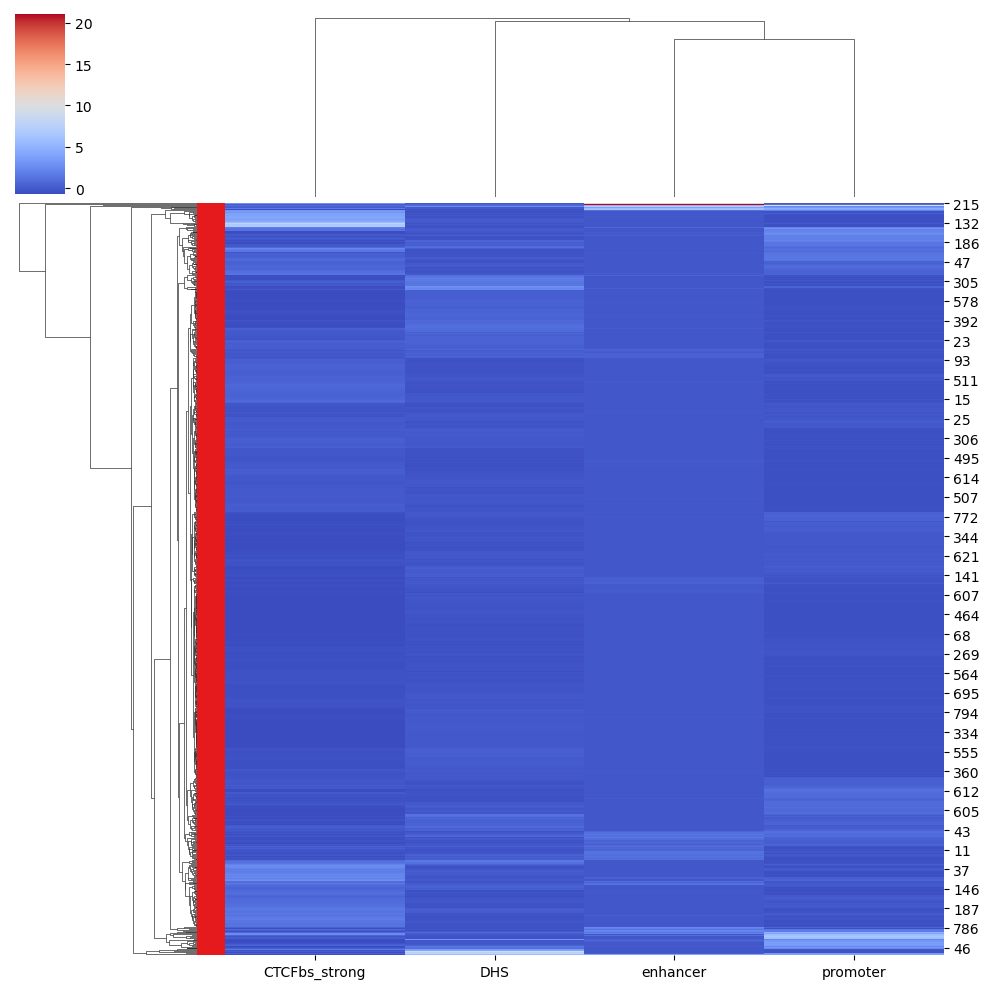

In [27]:
# Generate a clustermap 
# lut = dict(zip(cpg_cluster.unique(), "rbg"))
# row_colors = cpg_cluster.map(lut)
colors = sns.color_palette("Set1", n_colors=k)
row_colors = [colors[label - 1] for label in labels] # So red (cluster 1) is hypo, blue (cluster 2) is hyper
sns.clustermap(RL_treatment_standardized, cmap='coolwarm', row_colors=row_colors)

# Display the heatmap
plt.show()

### K-means

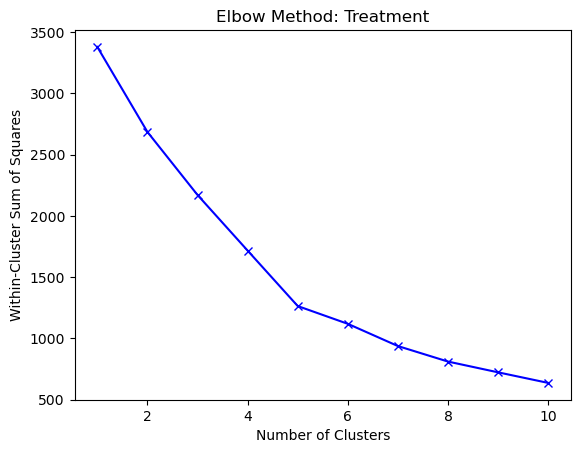

In [28]:
# Choosing the optimal number of clusters using k-means method instead
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(distances)
    inertias.append(kmeans.inertia_)

# Plot the number of clusters against the within-cluster sum of squares
plt.plot(range(1, 11), inertias, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method: Treatment')
plt.show()

In [29]:
# K-means clustering using 5 clusters (optimal)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=100)
kmeans.fit(distances)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

silhouette_avg = silhouette_score(distances, labels)
print("The average silhouette coefficient is :", silhouette_avg)
calinski = calinski_harabasz_score(distances, labels)
print("The average Calinski-Harabasz index is :", calinski)
davies = davies_bouldin_score(distances, labels)
print("The average Davies-Bouldin index is :", davies)

The average silhouette coefficient is : 0.5908063662832516
The average Calinski-Harabasz index is : 351.6490245826411
The average Davies-Bouldin index is : 0.7654047093618035


In [30]:
# K-means clustering using 2 clsuters
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=100)
kmeans.fit(distances)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

silhouette_avg = silhouette_score(distances, labels)
print("The average silhouette coefficient is :", silhouette_avg)
calinski = calinski_harabasz_score(distances, labels)
print("The average Calinski-Harabasz index is :", calinski)
davies = davies_bouldin_score(distances, labels)
print("The average Davies-Bouldin index is :", davies)

The average silhouette coefficient is : 0.745105661924046
The average Calinski-Harabasz index is : 218.30597042711352
The average Davies-Bouldin index is : 1.2813955744849586


### PCA

In [31]:
k = 2 # Number of clusters 
labels = fcluster(linkage_matrix, k, criterion='maxclust') 
silhouette_avg = silhouette_score(distances, labels)
print("The average silhouette coefficient is :", silhouette_avg)

The average silhouette coefficient is : 0.905901430035035


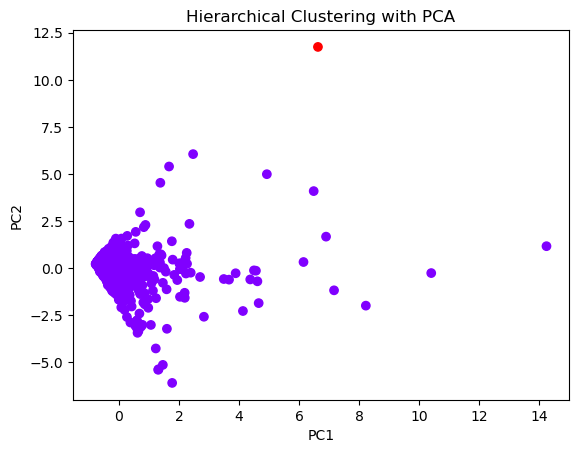

In [32]:
# Perform PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
embedding = pca.fit_transform(distances)

# Plot the data points in a scatterplot based on the clustering labels
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Hierarchical Clustering with PCA')
plt.show()

Variance explained by the first two PCs: 0.5798549128773226


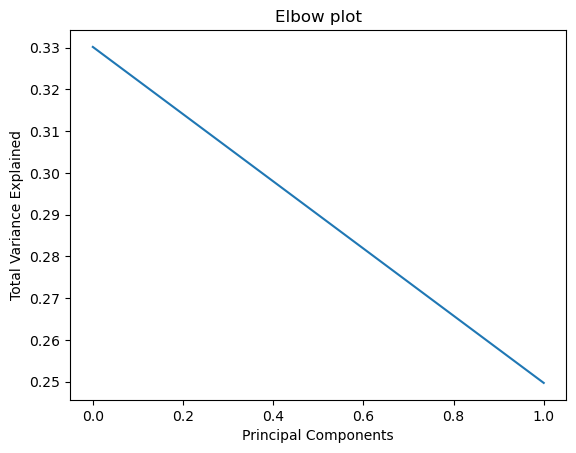

In [33]:
total_variance = pca.explained_variance_ratio_ # Total variance explained against the principal components
print('Variance explained by the first two PCs:', total_variance[0]+total_variance[1])

plt.figure()
plt.plot(total_variance)
plt.xlabel('Principal Components')
plt.ylabel('Total Variance Explained')
plt.title('Elbow plot')
plt.show()

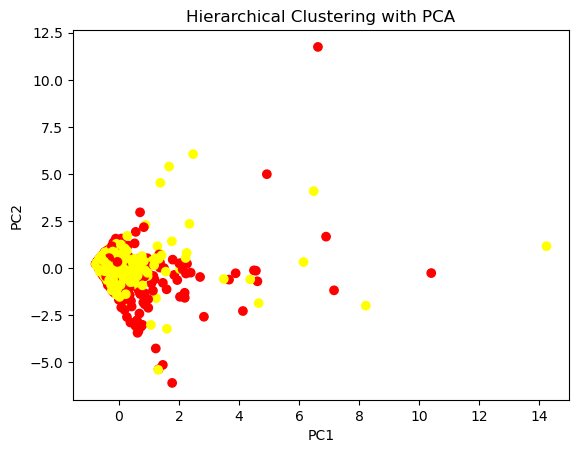

In [34]:
color_dict = {'high': 'red', 'low': 'yellow'} # Creating a dictionary mapping each diagnosis to a color
cpg_cluster_colored = cpg_cluster.map(color_dict)

# Plot the data points in a scatterplot based on the CpG clusters
plt.scatter(embedding[:, 0], embedding[:, 1], c=cpg_cluster_colored, cmap='rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Hierarchical Clustering with PCA')
plt.show()

### Random forest

In [35]:
# Splitting the data into training and testing sets for features (X) and labels (y)
X = RL_treatment_standardized
y = cpg_cluster
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, max_depth=5) # Creating a Random Forest classifier with 100 trees 
                                                          # and a maximum depth of 5

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test) # Predicting the target variable for new data

# Evaluating the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.5088757396449705


In [36]:
unique_labels = np.unique(y_test)
print(unique_labels)

['high' 'low']


Text(0.5, 1.0, 'Confusion Matrix')

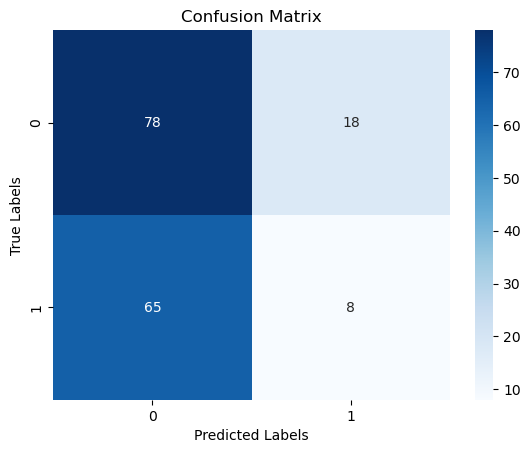

In [37]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels") 
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [19]:
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': RL_treatment_standardized.columns.values, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False) # Sorting features by importance
feature_importances

,feature,importance
3,CTCFbs_strong,0.336845
1,enhancer,0.250975
0,DHS,0.220742
2,promoter,0.191438


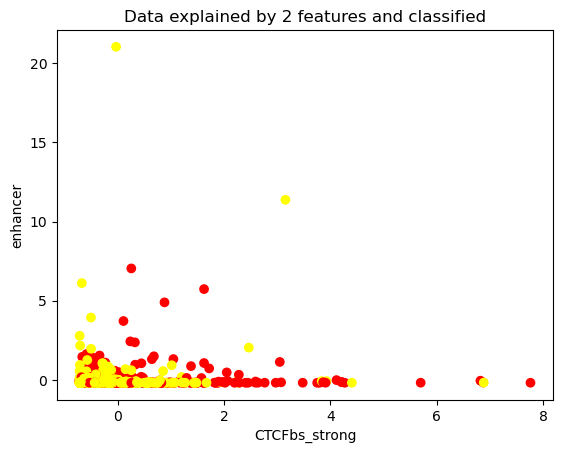

In [20]:
plt.scatter(RL_treatment_standardized.iloc[:,3], RL_treatment_standardized.iloc[:,1], c=cpg_cluster_colored)
plt.xlabel('CTCFbs_strong')
plt.ylabel('enhancer')
plt.title('Data explained by 2 features and classified')
plt.show()

# 2. CpG clusters to closest RL

## Infection

In [30]:
# Load methylation clusters data as a pandas DataFrame
RL_infection = pd.read_csv('Data/closest_RL_infection_g1.csv', index_col=0)
infection_cpgs_high = pd.read_csv('Data/infection_cpgs_high.csv', index_col=0)
infection_cpgs_low = pd.read_csv('Data/infection_cpgs_low.csv', index_col=0)

# Classifying dataframe with CpG cluster type (i.e., high vs low methylation)
CpG_cluster = []

for cpg in RL_infection.loc[:,'CpG_ID']:
    for high_cluster_id in infection_cpgs_high.loc[:,'CpG_ID']:
        if cpg == high_cluster_id:
            CpG_cluster.append('high')
    for low_cluster_id in infection_cpgs_low.loc[:,'CpG_ID']:
        if cpg == low_cluster_id:
            CpG_cluster.append('low')

RL_infection['CpG_cluster'] = CpG_cluster
RL_infection_closestRL = RL_infection[['closest_RL','CpG_cluster']]
RL_infection_closestRL

,closest_RL,CpG_cluster
0,promoter,low
1,DHS,low
2,enhancer,low
3,enhancer,low
4,DHS,low
...,...,...
425,enhancer,low
426,enhancer,low
427,DHS,low
428,DHS,low


In [23]:
# Separating into two dataframes each for DMP cluster
closestRL_infection_high = RL_infection_closestRL[RL_infection_closestRL['CpG_cluster'] == 'high']
closestRL_infection_low = RL_infection_closestRL[RL_infection_closestRL['CpG_cluster'] == 'low']

closestRL_infection_high.to_csv('Data/closestRL_infection_high.csv')
closestRL_infection_low.to_csv('Data/closestRL_infection_low.csv')

In [32]:
# Counts for each RL
infection_high_count_promoter = (closestRL_infection_high['closest_RL'] == 'promoter').sum()
infection_high_count_DHS = (closestRL_infection_high['closest_RL'] == 'DHS').sum()
infection_high_count_enhancer = (closestRL_infection_high['closest_RL'] == 'enhancer').sum()
infection_high_count_CTCFbs_strong = (closestRL_infection_high['closest_RL'] == 'CTCFbs_strong').sum()

infection_low_count_promoter = (closestRL_infection_low['closest_RL'] == 'promoter').sum()
infection_low_count_DHS = (closestRL_infection_low['closest_RL'] == 'DHS').sum()
infection_low_count_enhancer = (closestRL_infection_low['closest_RL'] == 'enhancer').sum()
infection_low_count_CTCFbs_strong = (closestRL_infection_low['closest_RL'] == 'CTCFbs_strong').sum()

print(infection_high_count_promoter)
print(infection_high_count_DHS)
print(infection_high_count_enhancer)
print(infection_high_count_CTCFbs_strong)

print(infection_low_count_promoter)
print(infection_low_count_DHS)
print(infection_low_count_enhancer)
print(infection_low_count_CTCFbs_strong)

22
80
40
1
49
140
88
10


Text(0.5, 0, 'Infection CpG clusters')

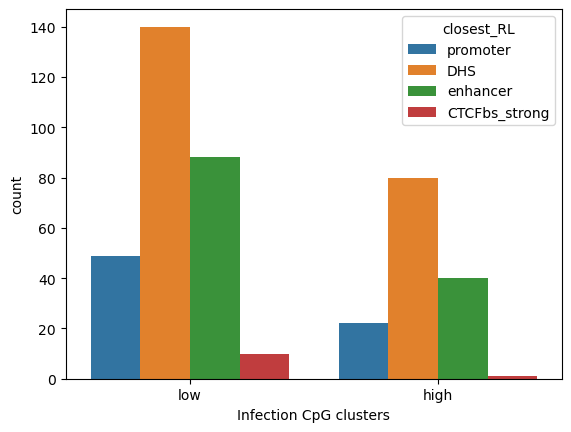

In [153]:
# Bar graphs for closest RL for each CpG cluster (i.e., hyper vs hypo)
sns.countplot(x='CpG_cluster', hue='closest_RL', data=RL_infection_closestRL, dodge=True)
plt.xlabel('Infection CpG clusters')

In [182]:
# Normalized
# Separate the DataFrame into two based on the CpG clusters
hyper_df = RL_infection_closestRL[RL_infection_closestRL['CpG_cluster'] == 'high']
hypo_df = RL_infection_closestRL[RL_infection_closestRL['CpG_cluster'] == 'low']

# Count for each RL
low_promoter_counts = hypo_df['closest_RL'].value_counts()['promoter']
low_DHS_counts = hypo_df['closest_RL'].value_counts()['DHS']
low_enhancer_counts = hypo_df['closest_RL'].value_counts()['enhancer']
low_CTCFbs_strong_counts = hypo_df['closest_RL'].value_counts()['CTCFbs_strong']

high_promoter_counts = hyper_df['closest_RL'].value_counts()['promoter']
high_DHS_counts = hyper_df['closest_RL'].value_counts()['DHS']
high_enhancer_counts = hyper_df['closest_RL'].value_counts()['enhancer']
high_CTCFbs_strong_counts = hyper_df['closest_RL'].value_counts()['CTCFbs_strong']

# Normalizing
low_weighted_promoter = low_promoter_counts/214308 
low_weighted_DHS = low_DHS_counts/3465057
low_weighted_enhancer = low_enhancer_counts/3586115
low_weighted_CTCFbs_strong = low_CTCFbs_strong_counts/782005

high_weighted_promoter = high_promoter_counts/214308
high_weighted_DHS = high_DHS_counts/3465057
high_weighted_enhancer = high_enhancer_counts/3586115
high_weighted_CTCFbs_strong = high_CTCFbs_strong_counts/782005

# Concatenating into a df
RL_infection_weighted_low = {'CpG cluster': ['low', 'low', 'low', 'low'],
                        'RL': ['promoter', 'DHS', 'enhancer', 'CTCFbs_strong'],
                        'counts': [low_weighted_promoter, low_weighted_DHS, low_weighted_enhancer, 
                                   low_weighted_CTCFbs_strong]}
RL_infection_weighted_low_df = pd.DataFrame(RL_infection_weighted_low)

RL_infection_weighted_high = {'CpG cluster': ['high', 'high', 'high', 'high'],
                        'RL': ['promoter', 'DHS', 'enhancer', 'CTCFbs_strong'],
                        'counts': [high_weighted_promoter, high_weighted_DHS, high_weighted_enhancer, 
                                   high_weighted_CTCFbs_strong]}
RL_infection_weighted_high_df = pd.DataFrame(RL_infection_weighted_high)

RL_infection_weighted_df = pd.concat([RL_infection_weighted_low_df, RL_infection_weighted_high_df], axis=0)
RL_infection_weighted_df['counts'] = RL_infection_weighted_df['counts'].mul(100) # Multiply values in column 
# 'counts' by a constant
RL_infection_weighted_df


,CpG cluster,RL,counts
0,low,promoter,0.022864
1,low,DHS,0.004040
2,low,enhancer,0.002454
3,low,CTCFbs_strong,0.001279
0,high,promoter,0.010266
1,high,DHS,0.002309
2,high,enhancer,0.001115
3,high,CTCFbs_strong,0.000128


Text(0.5, 0, 'Infection CpG clusters')

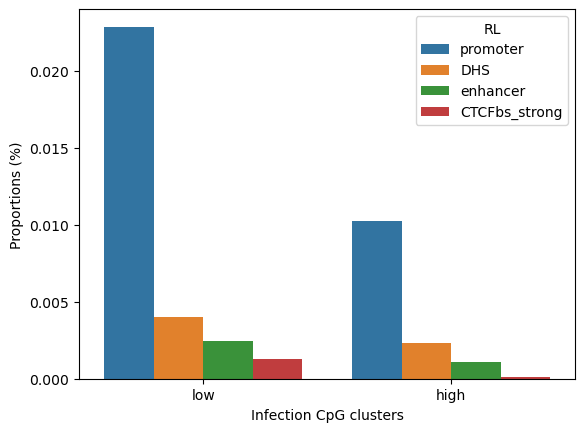

In [184]:
# Bar graphs 
sns.barplot(x='CpG cluster', y='counts', hue='RL', data=RL_infection_weighted_df)
plt.ylabel('Proportions (%)')
plt.xlabel('Infection CpG clusters')

In [ ]:
# Mann-Whitney U test
# Separate the data into two groups
low = methylation_data_infection[methylation_data_infection['CpG_cluster'] == 'low']['Mean β-value']
high = methylation_data_infection[methylation_data_infection['CpG_cluster'] == 'high']['Mean β-value']

statistic, p_value = mannwhitneyu(low, high)
print('Mann-Whitney U statistic:', statistic)
print('p-value:', p_value)

## Treatment

In [24]:
# Load methylation clusters data as a pandas DataFrame
RL_treatment = pd.read_csv('Data/closest_RL_treatment_g2.csv', index_col=0)
treatment_cpgs_high = pd.read_csv('Data/treatment_cpgs_high.csv', index_col=0)
treatment_cpgs_low = pd.read_csv('Data/treatment_cpgs_low.csv', index_col=0)

# Classifying dataframe with CpG cluster type (i.e., high vs low methylation)
CpG_cluster = []

for cpg in RL_treatment.loc[:,'CpG_ID']:
    for high_cluster_id in treatment_cpgs_high.loc[:,'CpG_ID']:
        if cpg == high_cluster_id:
            CpG_cluster.append('high')
    for low_cluster_id in treatment_cpgs_low.loc[:,'CpG_ID']:
        if cpg == low_cluster_id:
            CpG_cluster.append('low')

RL_treatment['CpG_cluster'] = CpG_cluster
RL_treatment_closestRL = RL_treatment[['closest_RL','CpG_cluster']]
RL_treatment_closestRL

,closest_RL,CpG_cluster
0,promoter,high
1,promoter,high
2,DHS,low
3,promoter,high
4,enhancer,low
...,...,...
840,enhancer,high
841,DHS,low
842,promoter,low
843,promoter,low


In [25]:
# Separating into two dataframes each for DMP cluster
closestRL_treatment_high = RL_treatment_closestRL[RL_treatment_closestRL['CpG_cluster'] == 'high']
closestRL_treatment_low = RL_treatment_closestRL[RL_treatment_closestRL['CpG_cluster'] == 'low']

closestRL_treatment_high.to_csv('Data/closestRL_treatment_high.csv')
closestRL_treatment_low.to_csv('Data/closestRL_treatment_low.csv')

In [29]:
# Counts for each RL
treatment_high_count_promoter = (closestRL_treatment_high['closest_RL'] == 'promoter').sum()
treatment_high_count_DHS = (closestRL_treatment_high['closest_RL'] == 'DHS').sum()
treatment_high_count_enhancer = (closestRL_treatment_high['closest_RL'] == 'enhancer').sum()
treatment_high_count_CTCFbs_strong = (closestRL_treatment_high['closest_RL'] == 'CTCFbs_strong').sum()

treatment_low_count_promoter = (closestRL_treatment_low['closest_RL'] == 'promoter').sum()
treatment_low_count_DHS = (closestRL_treatment_low['closest_RL'] == 'DHS').sum()
treatment_low_count_enhancer = (closestRL_treatment_low['closest_RL'] == 'enhancer').sum()
treatment_low_count_CTCFbs_strong = (closestRL_treatment_low['closest_RL'] == 'CTCFbs_strong').sum()

print(treatment_high_count_promoter)
print(treatment_high_count_DHS)
print(treatment_high_count_enhancer)
print(treatment_high_count_CTCFbs_strong)

print(treatment_low_count_promoter)
print(treatment_low_count_DHS)
print(treatment_low_count_enhancer)
print(treatment_low_count_CTCFbs_strong)

81
249
149
14
49
188
104
11


Text(0.5, 0, 'Treatment CpG clusters')

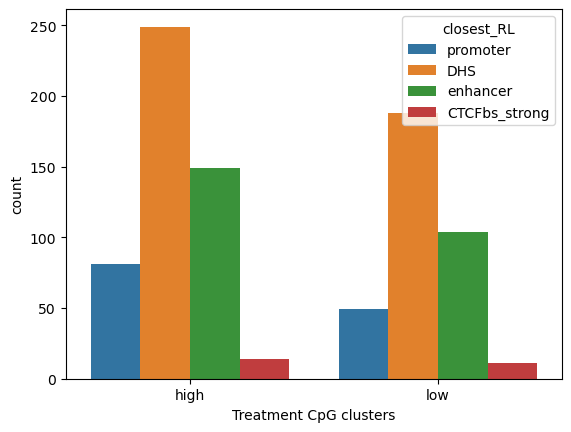

In [26]:
# Bar graphs for closest RL for each CpG cluster (i.e., hyper vs hypo)
sns.countplot(x='CpG_cluster', hue='closest_RL', data=RL_treatment_closestRL, dodge=True)
plt.xlabel('Treatment CpG clusters')

In [185]:
# Normalized
# Separate the DataFrame into two based on the CpG clusters
hyper_df = RL_treatment_closestRL[RL_treatment_closestRL['CpG_cluster'] == 'high']
hypo_df = RL_treatment_closestRL[RL_treatment_closestRL['CpG_cluster'] == 'low']

# Count for each RL
low_promoter_counts = hypo_df['closest_RL'].value_counts()['promoter']
low_DHS_counts = hypo_df['closest_RL'].value_counts()['DHS']
low_enhancer_counts = hypo_df['closest_RL'].value_counts()['enhancer']
low_CTCFbs_strong_counts = hypo_df['closest_RL'].value_counts()['CTCFbs_strong']

high_promoter_counts = hyper_df['closest_RL'].value_counts()['promoter']
high_DHS_counts = hyper_df['closest_RL'].value_counts()['DHS']
high_enhancer_counts = hyper_df['closest_RL'].value_counts()['enhancer']
high_CTCFbs_strong_counts = hyper_df['closest_RL'].value_counts()['CTCFbs_strong']

# Normalizing
low_weighted_promoter = low_promoter_counts/214308
low_weighted_DHS = low_DHS_counts/3465057
low_weighted_enhancer = low_enhancer_counts/3586115
low_weighted_CTCFbs_strong = low_CTCFbs_strong_counts/782005

high_weighted_promoter = high_promoter_counts/214308
high_weighted_DHS = high_DHS_counts/3465057
high_weighted_enhancer = high_enhancer_counts/3586115
high_weighted_CTCFbs_strong = high_CTCFbs_strong_counts/782005

# Concatenating into a df
RL_treatment_weighted_low = {'CpG cluster': ['low', 'low', 'low', 'low'],
                        'RL': ['promoter', 'DHS', 'enhancer', 'CTCFbs_strong'],
                        'counts': [low_weighted_promoter, low_weighted_DHS, low_weighted_enhancer, 
                                   low_weighted_CTCFbs_strong]}
RL_treatment_weighted_low_df = pd.DataFrame(RL_treatment_weighted_low)

RL_treatment_weighted_high = {'CpG cluster': ['high', 'high', 'high', 'high'],
                        'RL': ['promoter', 'DHS', 'enhancer', 'CTCFbs_strong'],
                        'counts': [high_weighted_promoter, high_weighted_DHS, high_weighted_enhancer, 
                                   high_weighted_CTCFbs_strong]}
RL_treatment_weighted_high_df = pd.DataFrame(RL_treatment_weighted_high)

RL_treatment_weighted_df = pd.concat([RL_treatment_weighted_low_df, RL_treatment_weighted_high_df], axis=0)
RL_treatment_weighted_df['counts'] = RL_treatment_weighted_df['counts'].mul(100) # Multiply values in column 'counts' 
# by a constant
RL_treatment_weighted_df


,CpG cluster,RL,counts
0,low,promoter,0.022864
1,low,DHS,0.005426
2,low,enhancer,0.002900
3,low,CTCFbs_strong,0.001407
0,high,promoter,0.037796
1,high,DHS,0.007186
2,high,enhancer,0.004155
3,high,CTCFbs_strong,0.001790


Text(0.5, 0, 'Treatment CpG clusters')

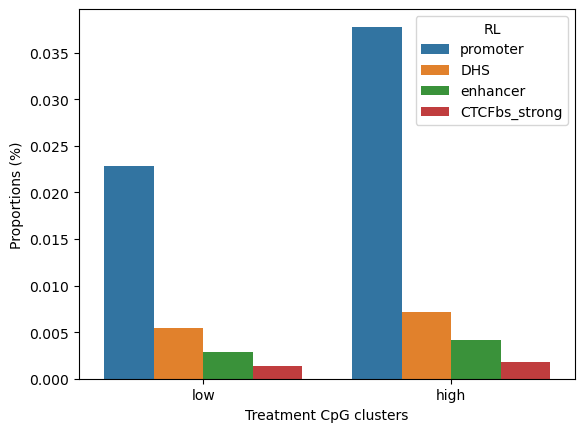

In [186]:
# Bar graphs 
sns.barplot(x='CpG cluster', y='counts', hue='RL', data=RL_treatment_weighted_df)
plt.ylabel('Proportions (%)')
plt.xlabel('Treatment CpG clusters')